In [1]:
import pandas as pd 
import numpy as np
from entropy_pooling import views
from entropy_pooling import entropy_minimizer
from entropy_pooling import markoviz_optimizer

In [2]:
data_raw = pd.read_excel("data/data.xlsx").dropna(axis=1, how='all')
weights = data_raw[["Weight"]]
scenarios = data_raw.drop(columns = ["Weight"])/100

In [3]:
(A,b,C,d) = views.load(views_sheet_name = "data/sample_portfolio2_views.xlsx", views_subsheet_name = 0);

In [4]:
c = 1
p = np.array(weights)
m,n = p.shape

posterior = entropy_minimizer.full_confidence_posterior(p, A, b, C, d, verbose = False)
weighted_posterior = entropy_minimizer.confidence_weighted_posterior(p, posterior, c)

In [5]:
scenarios *= 12 # annualize

In [6]:
total = 417000000

deltas, asset_names = markoviz_optimizer.load_asset_deltas("data/sample_portfolio2_deltas.xlsx")

deltas[:,:13] *= 100 # deltas are not percent but unitless numbers.
# Unit delta states that 1% change in factor causes 1% change in asset.

asset_scenarios = markoviz_optimizer.asset_scenarios(scenarios, deltas, asset_names)

loaded_constraints = pd.read_excel("data/sample_portfolio2_constrs.xlsx").dropna(axis=1, how='all')
manual_constraints = (loaded_constraints.iloc[:,:-2],
                      loaded_constraints.iloc[:,-2],
                      loaded_constraints.iloc[:,-1])

In [10]:
optimal_x = markoviz_optimizer.optimizer(asset_scenarios,
                                         posterior,
                                         mu_0 = 0.05 * total,
                                         manual_constraints = manual_constraints,
                                         visualize = False,
                                         verbose = 1).x

for i, col in enumerate(asset_scenarios.columns):
  #print("{}: {}%".format(col, np.round(optimal_x[i]*100,decimals = 1)))
  print("{}: {}".format(col, np.round(optimal_x[i],decimals = 0)))

The optimization was succesful: False
The optimization was terminated due to: 
Inequality constraints incompatible
Global Equities: 5046959.0
DM Equities: 4835464.0
EM Equities: 19512138.0
European Equities: 18951496.0
US Equities: 6808579.0
EUR Money Markets: 48796732.0
EUR Government Bonds: 86504250.0
EUR Covered Bonds: 49652286.0
EUR Investment Grade Corporate Bonds: 47553649.0
European High Yield Corporate Bonds: 35824075.0
EMD Hard Currency: 52588915.0
Hedge Funds: 17129248.0
Listed Private Equity: 23796208.0
Technical Provisions: 1.0
IR Hedges: 1.0


In [ ]:
retscen = (asset_scenarios @ optimal_x) / total # return scenarios
mu_opt, vol_opt = retscen.dot(posterior), np.sqrt(np.cov(retscen, aweights=posterior)) # weighted avg and std
mu_opt * 100, vol_opt * 100 # the mean and variance of the optimal portfolio in percent

(2.727646511193243, 6.291373269341093)

The optimization was succesful: False
The optimization was terminated due to: 
Positive directional derivative for linesearch
Global Equities: -13281072.0
DM Equities: -10604109.0
EM Equities: 4650645.0
European Equities: 745347.0
US Equities: 40601271.0
EUR Money Markets: 223053212.0
EUR Government Bonds: 86631326.0
EUR Covered Bonds: 62067726.0
EUR Investment Grade Corporate Bonds: -39142709.0
European High Yield Corporate Bonds: 25824290.0
EMD Hard Currency: 7419622.0
Hedge Funds: 24104530.0
Listed Private Equity: 4929921.0


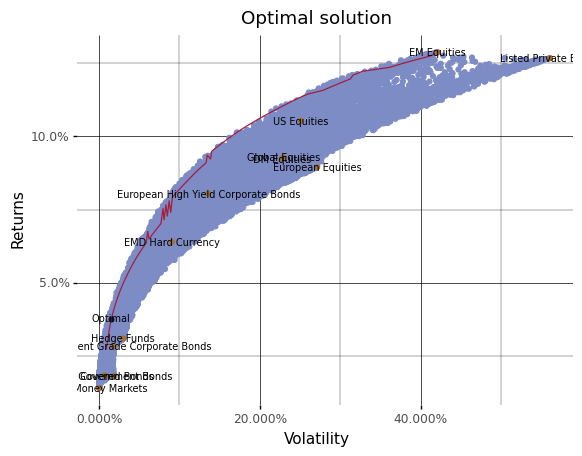

In [ ]:
# Do the same optimization but now without the extra assets
optimal_x2 = markoviz_optimizer.optimizer(asset_scenarios.iloc[:,:13],
                                         posterior,
                                         mu_0 = 0.05 * total,
                                         total = total,
                                         manual_constraints = (manual_constraints[0].iloc[:15,:13],
                                                              manual_constraints[1][:15],
                                                              manual_constraints[2][:15]),
                                         allow_shorting = False,
                                         visualize = True,
                                         verbose = 1).x
for i, col in enumerate(asset_scenarios.columns[:13]):
  #print("{}: {}%".format(col, np.round(optimal_x[i]*100,decimals = 1)))
  print("{}: {}".format(col, np.round(optimal_x[i],decimals = 0)))

In [ ]:
# Mu and vola of the other optimal portfolio
retscen2 = (asset_scenarios.iloc[:,:13] @ optimal_x2) / total
mu_opt2, vol_opt2 = retscen2.dot(posterior), np.sqrt(np.cov(retscen2, aweights=posterior))
mu_opt2 * 100, vol_opt2 * 100

(3.7861006229446303, 12.027148104877208)

Text(0.5, 1.0, 'Optimal portfolio and components')

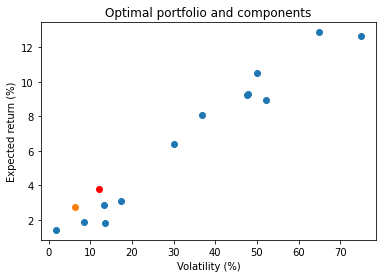

In [ ]:
# Simple scatter plot
from plotnine import ggplot, geom_point, aes, geom_line, labs, geom_text, position_jitter, theme, element_text, theme_linedraw, element_line, element_rect, scale_y_continuous, scale_x_continuous
import matplotlib.pyplot as plt
plt.scatter(asset_scenarios.iloc[:,:13].apply(lambda x: np.sqrt(np.cov(x, aweights=posterior))) * 100,
            asset_scenarios.iloc[:,:13].T @ posterior * 100)
plt.scatter(vol_opt * 100, mu_opt * 100)
plt.scatter(vol_opt2 * 100, mu_opt2 * 100, color = 'red')
plt.xlabel('Volatility (%)'); plt.ylabel('Expected return (%)')
plt.title('Optimal portfolio and components')

In [ ]:
# Same in ggplot plus random sample cloud
vol = asset_scenarios.iloc[:,:13].apply(lambda x: np.sqrt(np.cov(x, aweights=posterior))) * 100
mu  = asset_scenarios.iloc[:,:13].T @ posterior * 100
extra_mu = asset_scenarios.iloc[:,13:15].T @ posterior * 100

generated_points = 10000
port_returns = np.array([])
port_vol = np.array([])
for i in range(0, generated_points):
    y = np.random.rand(13)**10
    y = y/np.sum(y)
    port_returns = np.append(port_returns, mu @ y + np.sum(extra_mu) / total * 100)
    port_vol     = np.append(port_vol,     np.sqrt(np.cov(np.dot(asset_scenarios.iloc[:,:13], y) * 100 + (asset_scenarios.iloc[:,13:15] @ np.array([1, 1]) * 100) / total, aweights = posterior)))

generated_df = pd.DataFrame(list(zip(port_vol, port_returns)), columns = ["Volatility", "Returns"])

In [ ]:
plot = (ggplot()
        + theme(legend_title = element_text(
                family = "Calibri",
                colour = "brown",
                face = "bold",
                size = 12))
        + theme(panel_grid_major = element_line(size = 0.5,
                                                linetype = 'solid',
                                                colour = "black"),
                panel_grid_minor = element_line(size = 0.25,
                                                linetype = 'solid',
                                                colour = "black"),
                panel_background = element_rect(fill = "white"))
        + labs(title="Optimal solution", y="Returns", x="Volatility")
#        + scale_y_continuous(labels=lambda l: ["%.1f%%" % (v * 100) for v in l])
#        + scale_x_continuous(labels=lambda l: ["%.3f%%" % (v * 100) for v in l])
        + geom_point(data = generated_df,
                     mapping = aes(x = "Volatility",
                        y = "Returns"),
                     color = "#7D8CC4"
                    )
#        + geom_line(data = frontier_df,
#                    mapping= aes(x = "Volatility",
#                        y = "Returns"),
#                    color = "#A61C3C"
#                    )
        + geom_point(mapping = aes(x = vol_opt * 100, y=mu_opt * 100),
                     color = "#FF0000",
                     #shape=13
                     )
        + geom_text(mapping = aes(x = vol_opt * 100, y=mu_opt * 100),
                     label = "Optimal",
                     nudge_y = -0.35,
                     #nudge_x = 0.5,
                     size = 7,
                     )
        + geom_point(aes(x = vol, y = mu),
                     color = "#A27035"
                     )
        + geom_text(aes(x = vol, y = mu),
                     label = scenarios.columns[:13],
                     #nudge_y = -0.02,
                     #nudge_x = 0.5,
                     size = 7,
                     position=position_jitter()
                     )

    )# .draw()

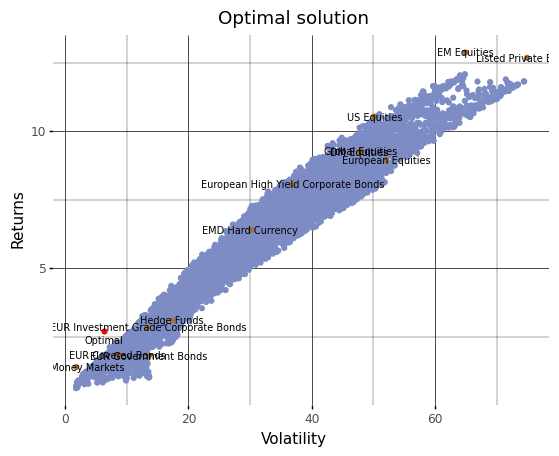

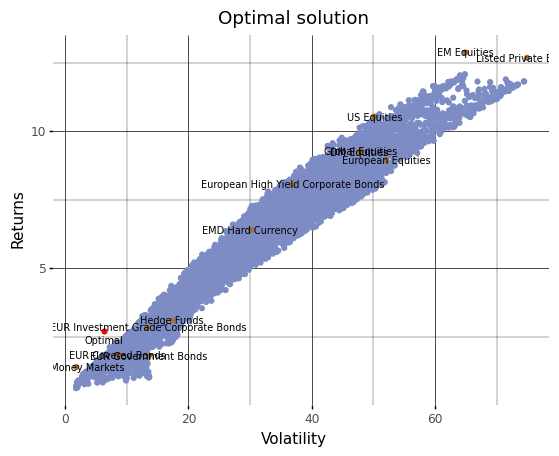

In [ ]:
plot # show

In [ ]:
plot.save('plotname.eps')